# Table of Contents
1. [Business Understanding](#Business-Understanding)

1. [Exploratory Data Analysis and Visualisation](#Exploratory-Data-Analysis)

1. [Churn Modeling](#Churn-Modeling)

    1. [Feature preprocessing](#Feature-preprocessing)
    1. [Churn prediction](#Churn-prediction)
    
1. [Marketing campaign: 20% discount churned custormers](#Marketing-campaign:-20%-discount-churned-customers)


In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from fancyimpute import KNN

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score, auc, brier_score_loss

from functools import reduce

random_state = np.random.RandomState(1)
np.random.seed(1) # for reproducibility

In [3]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 5)

pd.set_option('display.max_columns', None)

In [5]:
import os

In [6]:
os.chdir('../data')

# Load Data

In [26]:
# Read csv:
dates = ['contract_activation_date', 'contract_end_date', 'contract_fist_act_date', 'contract_last_mod_date',
         'contract_renewal_date']

# Train data
train_data = pd.read_csv('aily_case_training_data.csv', index_col='contract_id', parse_dates=dates)


train_hist_data = pd.read_csv('aily_case_training_hist_data.csv', parse_dates=['reference_date'], 
                              index_col='contract_id')
train_hist_data = train_hist_data.groupby('contract_id').mean()


train_output = pd.read_csv('aily_case_training_output.csv', index_col='contract_id')


# Test data
test_data = pd.read_csv('aily_case_test_data.csv', index_col='contract_id', parse_dates=dates)


test_hist_data = pd.read_csv('aily_case_test_hist_data.csv', parse_dates=['reference_date'], 
                             index_col='contract_id')
test_hist_data = test_hist_data.groupby('contract_id').mean()

In [8]:
train_datasets = (train_data, train_hist_data, train_output)
test_datasets = (test_data, test_hist_data)

train_dataset = pd.DataFrame(reduce(lambda x, y: x.join(y, on = x.index, how = 'left'), train_datasets))
test_dataset = pd.DataFrame(reduce(lambda x, y: x.join(y, on = x.index, how = 'left'), test_datasets))


dataset = pd.concat([train_dataset, test_dataset], axis = 0)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, d07d473503c6bef7cf1922fab1f88f3e to 44e27783ba74e3c10aba49fae358fe0b
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   company_category                     8221 non-null   object        
 1   campaing_code_elect                  0 non-null      float64       
 2   channel                              14846 non-null  object        
 3   elect_cons_at_12m                    20120 non-null  int64         
 4   gas_cons_at_12m                      20120 non-null  int64         
 5   elect_cons_last_month                20120 non-null  int64         
 6   contract_activation_date             20120 non-null  datetime64[ns]
 7   contract_end_date                    20118 non-null  datetime64[ns]
 8   contract_fist_act_date               4385 non-null   datetime64[ns]
 9   contract_last_mod_date        

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

<ul>
    <li>Service specific variables: (i) electricity and (ii) gas</li>
    <li>Person specific variables: tenure (contract duration in months), customer antiquity in years, gas subscription</li>
    <li>Money specific: (i) prices (energy, gas), (ii) margins</li>
    <li>Marketing campaigns: (i) number of active products, (ii) electricity campaigns first subscription, (iii) forecasted current discount</li>
</ul>

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Numeric Variables

In [41]:
numerics = ['int64', 'float64']
dataset = dataset.select_dtypes(include=numerics)

/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

ValueError: num must be 1 <= num <= 18, not 19

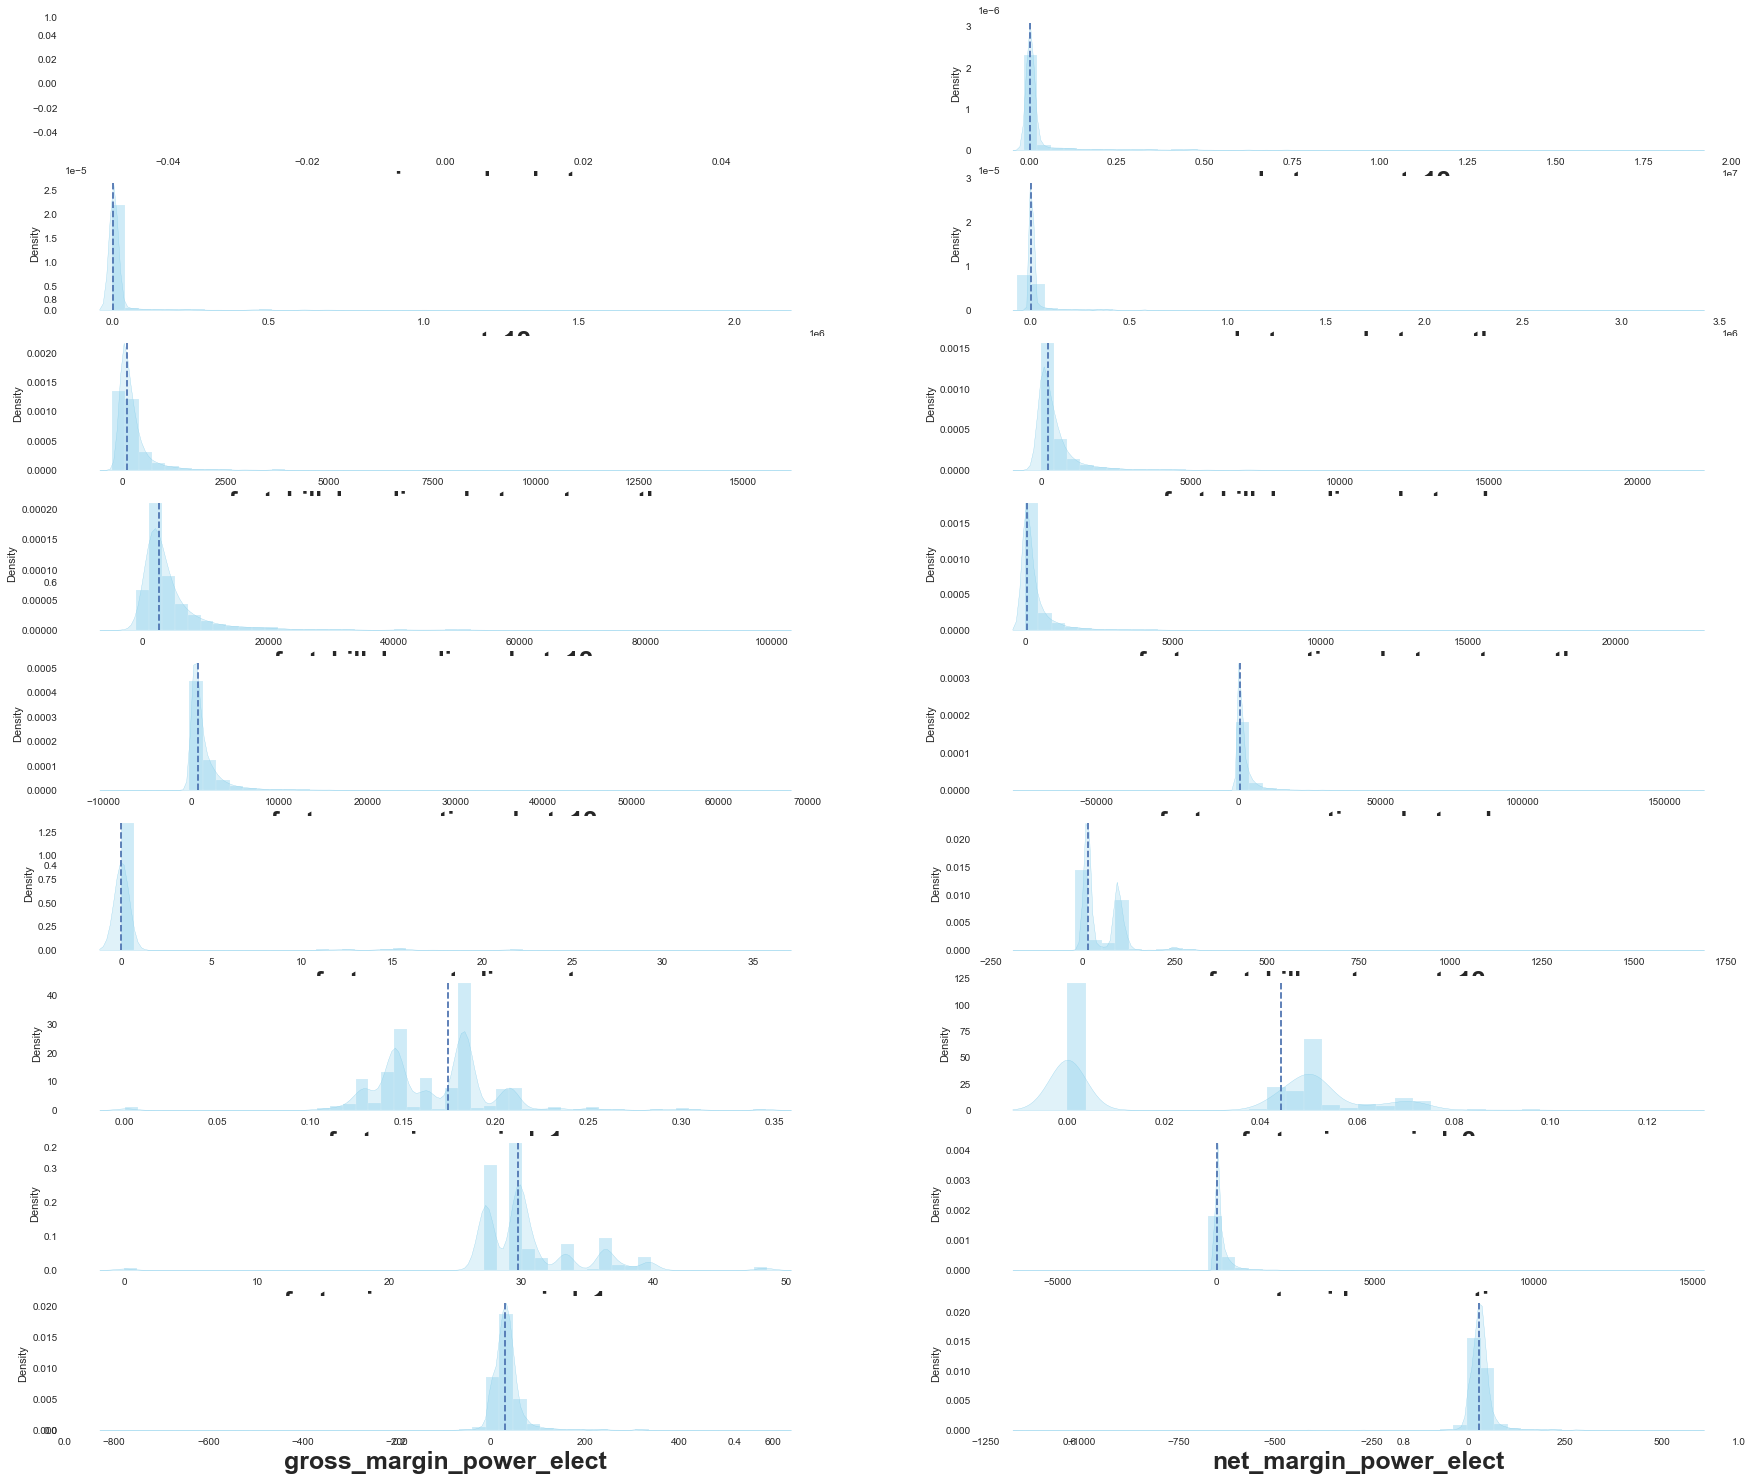

In [43]:
# Set initial plot options
sns.set_style('white')
fig, ax = plt.subplots(figsize = (30, 26))

# Loop over subplots
for i, col in enumerate(dataset.columns):
    ax = fig.add_subplot(9, 2, i+1)
    
    sns.distplot(dataset[col], 
                 color='skyblue',
                 kde_kws = {"shade":True},
                 kde=True,
                 ax=ax)
    
    # Add a vertical line
    plt.axvline(dataset[col].median(), ymax = 0.95, linestyle = "--")
    plt.xlabel(col, fontsize = 25, fontweight = "semibold")
    
# Despine visualizations
sns.despine(left=True)
fig.suptitle("Numerical variables", fontweight = "semibold", fontsize = 35)
    
plt.tight_layout()

plt.savefig('../images/numeric_vars.png')

### Categorical Variables

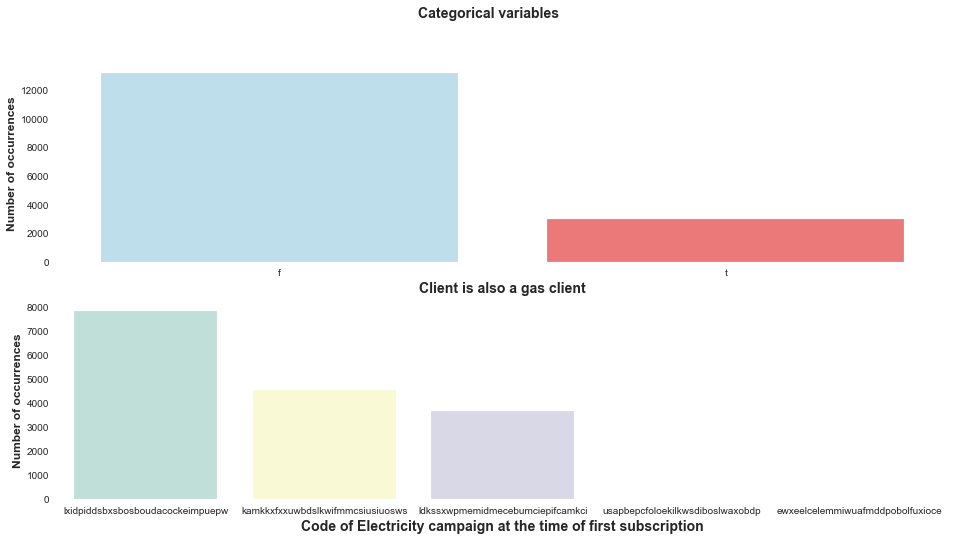

In [54]:
sns.set_style('white')
fig, axes = plt.subplots(2, 1, figsize = (16, 8))

# Create a count plot for variable 'client_got_gas'
sns.countplot(x = 'client_got_gas',
              data = train_dataset,
              palette = ['skyblue', 'r'],
              order = ['f', 't'],
              alpha = 0.6,
              ax = axes[0])

# Final styling touche
axes[0].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Client is also a gas client", fontweight = "semibold", fontsize = 14)

# Create a count plot for variable 'client_got_gas'
sns.countplot(x = 'code_elect_campaign_first_subs',
              data = train_dataset,
              palette = 'Set3',
              alpha = 0.6,
              ax = axes[1])

# Final styling touche
# axes[1].tick_params(labelrotation = 70)
axes[1].set_ylabel("Number of occurrences", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel('Code of Electricity campaign at the time of first subscription', fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Categorical variables", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/categorical_vars.png')
plt.show()

### Time Series Data

In [51]:
train_hist_data = pd.read_csv('aily_case_training_hist_data.csv', parse_dates=['reference_date'], 
                              index_col='contract_id')
test_hist_data = pd.read_csv('aily_case_training_hist_data.csv', parse_dates=['reference_date'], 
                              index_col='contract_id')

hist_data = pd.concat([train_hist_data, test_hist_data], axis = 0)

In [52]:
# Melt method for multiple linearplots
energy_melted = pd.melt(hist_data, id_vars='reference_date',
                 value_vars=['price_energy_1st_period', 'price_energy_2nd_period', 'price_energy_3rd_period'])

power_melted = pd.melt(hist_data, id_vars='reference_date',
                 value_vars=['price_power_1st_period', 'price_power_2nd_period', 'price_power_3rd_period'])

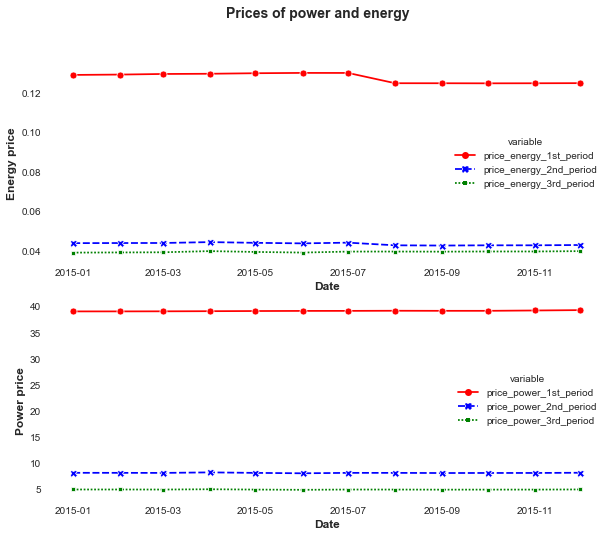

In [53]:
# Set initial plot options
sns.set_style('white')

# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Create a lineplot for time series of energy prices
sns.lineplot(x = 'reference_date', 
             y = "value", 
             # Set hue and linestyle by Attrition
             hue = "variable", 
             style = "variable", 
             data = energy_melted,
             # Change colors for each hue category
             palette = ['r', 'b', 'g'], 
             # Add points to lineplot and remove confidence interval
             markers = True, ci = None,
             ax = axes[0])

# Format subplot in axes
axes[0].set_ylabel("Energy price", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Date", fontsize = 12, fontweight = "semibold")


# Create a lineplot for time series of power prices
sns.lineplot(x = 'reference_date', 
             y = "value", 
             # Set hue and linestyle by Attrition
             hue = "variable", 
             style = "variable", 
             data = power_melted,
             # Change colors for each hue category
             palette = ['r', 'b', 'g'], 
             # Add points to lineplot and remove confidence interval
             markers = True, ci = None,
             ax = axes[1])

# Format subplot in axes
axes[1].set_ylabel("Power price", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel("Date", fontsize = 12, fontweight = "semibold")


# Despine plot
sns.despine()
plt.suptitle("Prices of power and energy", fontsize = 14, fontweight = "semibold")

plt.savefig('../images/time_series_vars.png')
plt.show()

<ul>
    <li>Consumption variables: they have low mean and follow positive skewed distributions and have fat tails in amont</li>
    <li>Price variables: 1st period is higher than 2nd and 3rd which may coincide with periods within a year</li>
    <li>Person specific variables: customers might be segmented according to: (i) antiquity in years (mean of 5 years), marketing campaigns</li>
</ul>

## Churned customers after a period of 3 months (March 2016)

In [10]:
round(train_output.groupby(['has_churned_over_next_3m']).size() / train_output.shape[0] * 100, 2)

has_churned_over_next_3m
0    90.09
1     9.91
dtype: float64

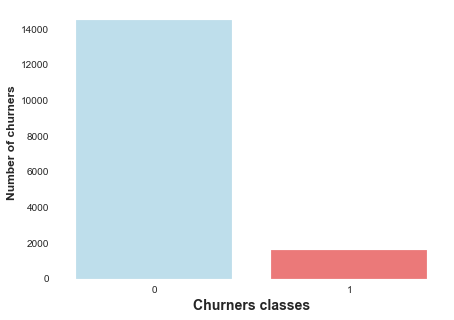

In [16]:
sns.set_style('white')
plt.figure(figsize=(7,5))

# Create a countplot
sns.countplot(x='has_churned_over_next_3m',
              data=train_output,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["skyblue", 'r'],
              alpha = 0.6)

# Final styling touche
plt.ylabel("Number of churners", fontsize = 12, fontweight = "semibold")
plt.xlabel("Churners classes", fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Distribution of Churners / non-Churners", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/churners.png')
plt.show()

## Churn Drivers (EDA)

### Churn drivers: price

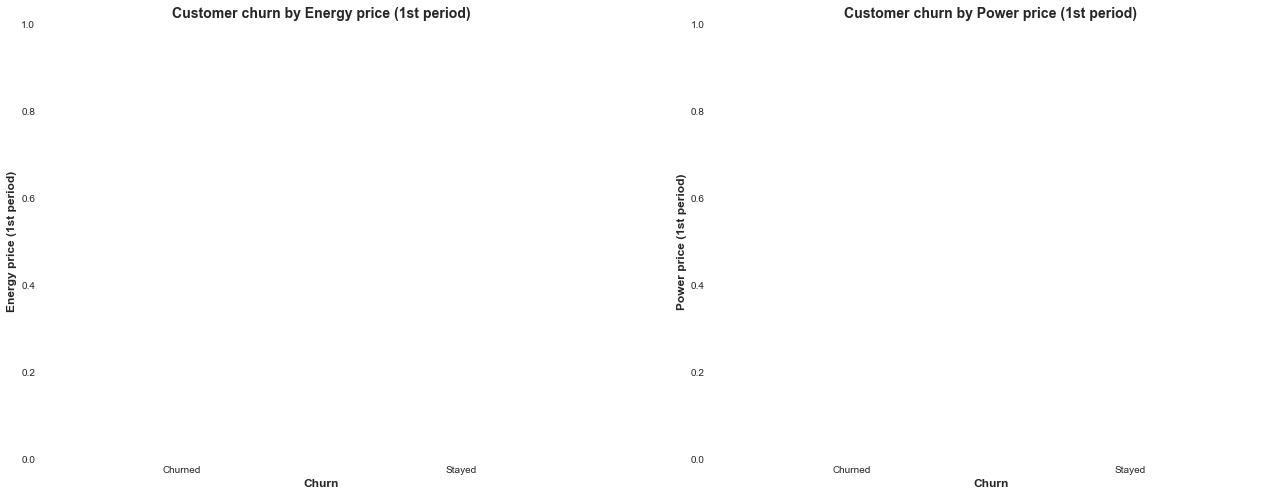

In [23]:
# Set initial plot options
sns.set_style('white')

# Create helper lists
columns_to_plot = ['price_energy_1st_period', 'price_power_1st_period']
titles_to_plot = ["Energy price (1st period)", "Power price (1st period)"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Iterate over each axes, and plot a boxplot with relevant columns/titles
for ax, column, title in zip(axes, columns_to_plot, titles_to_plot):
  
  # Create a boxplot
    sns.boxplot(x = 'has_churned_over_next_3m', 
                # Plot each column from columns_to_plot list
                y = column, 
                data = train_dataset,
                # Set the order for x-axis categories
                order = ["Churned", "Stayed"],
                # Change the width and line-width of each box-plot
                width = 0.4, 
                linewidth = 1.75,
                # Fix colors of churned (red) vs stayed (green)
                palette = ["r", "g"], 
                # Assign boxplot to an axes
                ax = ax)
  
    # Despine plot
    sns.despine()
    # Fix final styling for each axes
    ax.set_xlabel("Churn", fontsize = 12, fontweight = "semibold")
    ax.set_ylabel(title, fontsize = 12, fontweight = "semibold")
    ax.set_title("Customer churn by " + title, fontweight = "semibold", fontsize = 14)
    
plt.savefig('../images/churn_prices.png')
plt.show() 

<AxesSubplot:xlabel='has_churned_over_next_3m', ylabel='price_power_1st_period'>

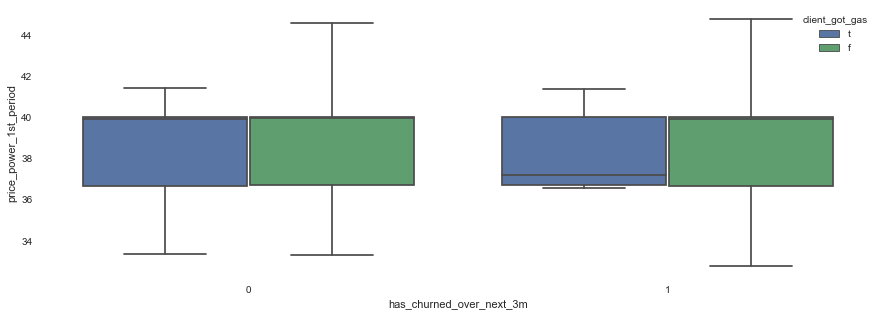

In [30]:
sns.boxplot(x = 'has_churned_over_next_3m',
            y = 'price_power_1st_period',
            data = train_dataset,
            sym = "",
            hue = "client_got_gas")

<AxesSubplot:xlabel='has_churned_over_next_3m', ylabel='gross_margin_power_elect'>

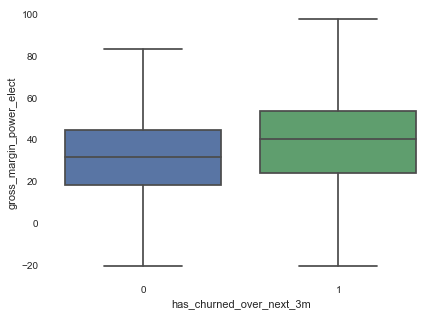

In [36]:
sns.set_style('white')
plt.figure(figsize=(7,5))

sns.boxplot(x = 'has_churned_over_next_3m',
            y = 'gross_margin_power_elect',
            data = train_dataset,
            sym = "",
            )

### Churn drivers: consumption

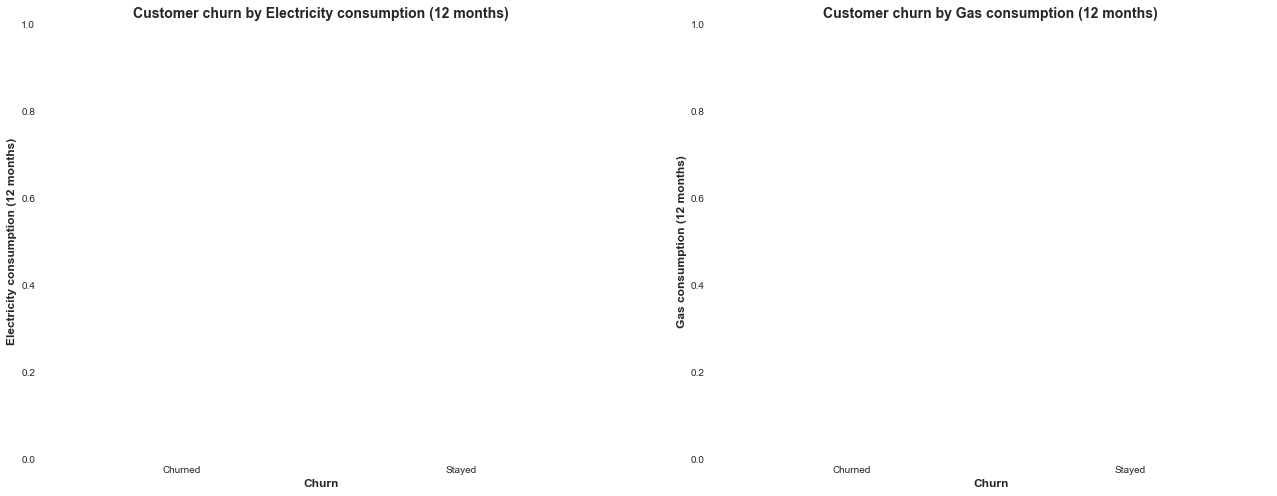

In [37]:
# Set initial plot options
sns.set_style('white')

# Create helper lists
columns_to_plot = ['elect_cons_at_12m', 'gas_cons_at_12m']
titles_to_plot = ["Electricity consumption (12 months)", "Gas consumption (12 months)"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Iterate over each axes, and plot a boxplot with relevant columns/titles
for ax, column, title in zip(axes, columns_to_plot, titles_to_plot):
  
  # Create a boxplot
    sns.boxplot(x = 'has_churned_over_next_3m', 
                # Plot each column from columns_to_plot list
                y = column, 
                data = train_dataset,
                # Set the order for x-axis categories
                order = ["Churned", "Stayed"],
                # Change the width and line-width of each box-plot
                width = 0.4, 
                linewidth = 1.75,
                # Fix colors of churned (red) vs stayed (green)
                palette = ["r", "g"], 
                # Assign boxplot to an axes
                ax = ax)
  
    # Despine plot
    sns.despine()
    # Fix final styling for each axes
    ax.set_xlabel("Churn", fontsize = 12, fontweight = "semibold")
    ax.set_ylabel(title, fontsize = 12, fontweight = "semibold")
    ax.set_title("Customer churn by " + title, fontweight = "semibold", fontsize = 14)
    
plt.savefig('../images/churn_driv_consump.png')
plt.show() 

### Churn drivers: loyalty

<AxesSubplot:xlabel='has_churned_over_next_3m', ylabel='number_active_products'>

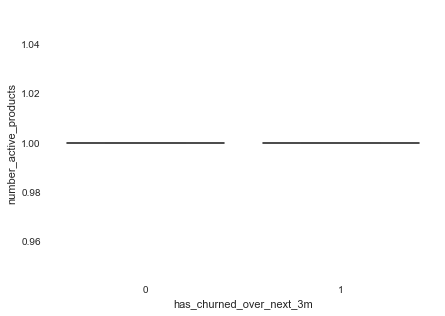

In [39]:
sns.set_style('white')
plt.figure(figsize=(7,5))

# Create a countplot
sns.countplot(x='has_churned_over_next_3m',
              data=train_dataset,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["r","skyblue"],
              alpha = 0.6)

# Final styling touche
plt.ylabel("Number of active products", fontsize = 12, fontweight = "semibold")
plt.xlabel("Churners classes", fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Number of active products per customer attrition", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/churn_driv_loyalty(1).png')
plt.show()

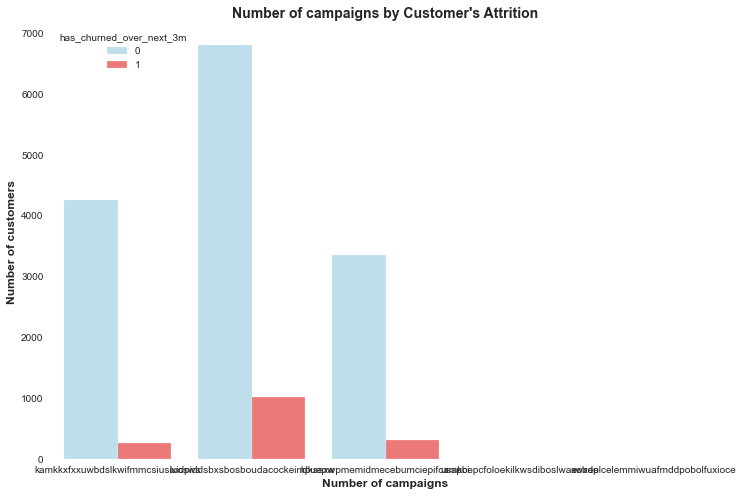

In [43]:
# Set initial plot options
sns.set_style('white')
plt.figure(figsize = (12, 8))

# Create a countplot
sns.countplot(x='code_elect_campaign_first_subs',
              # Group by Gender 
              hue = 'has_churned_over_next_3m', 
              data=train_dataset,
              # Set colour of hue and transperency
              palette = ['skyblue', 'r'],
              alpha = 0.6)

# Despine visualizations
sns.despine()
# Final styling touche
plt.ylabel("Number of customers", fontsize = 12, fontweight = "semibold")
plt.xlabel("Number of campaigns", fontsize = 12, fontweight = "semibold")
#plt.xticks(x, labels, rotation='vertical')
plt.title("Number of campaigns by Customer's Attrition", fontweight = "semibold", fontsize = 14)

plt.savefig('../images/churn_driv_loyalty(2).png')
plt.show()

In [32]:
train_dataset.groupby('has_churned_over_next_3m')['contract_renewal_date'].mean()

has_churned_over_next_3m
0   2014-08-14 18:59:02.771244032
1   2015-07-18 18:20:32.351097344
Name: contract_renewal_date, dtype: datetime64[ns]

### Cluster

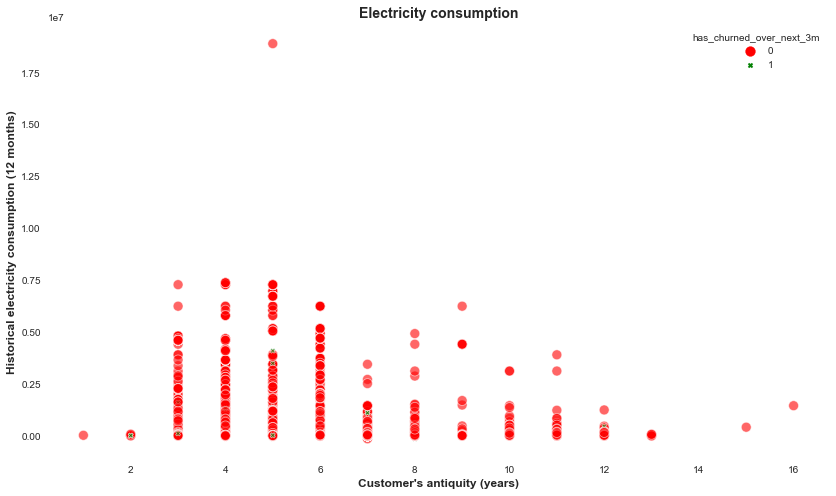

In [59]:
sns.set_style('white')
plt.figure(figsize = (14, 8))

# Create scatterplot
sns.scatterplot(x = "customer_antiquity_in_years", 
                y = "elect_cons_at_12m", 
                # Group by and change dot style and  by Attrition
                hue = "has_churned_over_next_3m",
                size = "has_churned_over_next_3m",  
                style = "has_churned_over_next_3m", 
                data = train_dataset, 
                # Change color of hue categories
                palette = ["r", "g"],
                alpha = 0.6)

# Despine plot
sns.despine()
# Final formatting touches
plt.xlabel("Customer's antiquity (years)", fontsize = 12, fontweight = "semibold")
plt.ylabel("Historical electricity consumption (12 months)", fontsize = 12, fontweight = "semibold")
plt.title("Electricity consumption", fontsize = 14, fontweight = "semibold")
plt.show()

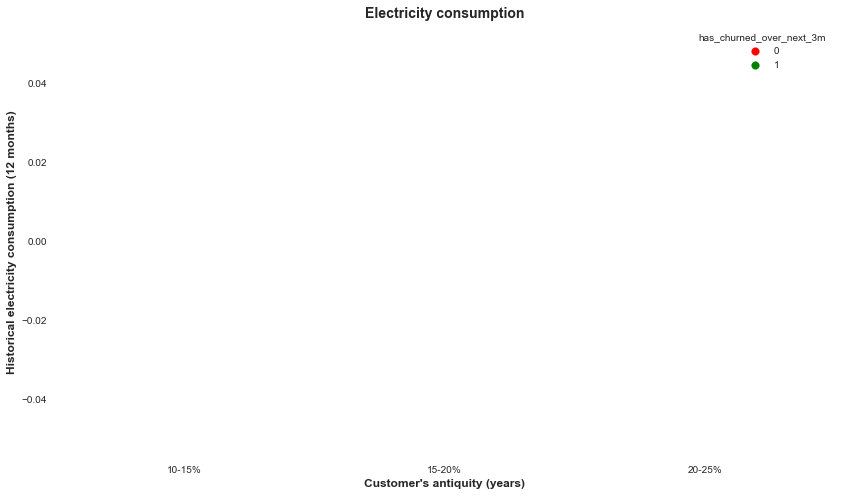

In [62]:
# Set initial plot options
sns.set_style('white')
plt.figure(figsize = (14, 8))

# Create swarmplot
sns.swarmplot(x = "subscribed_power", 
              y = "net_margin_power_elect", 
              # Group by Attrition
              hue = "has_churned_over_next_3m",
              data = train_dataset,
              # Order categories
              order = ['10-15%', '15-20%', '20-25%'],
              # Change color of hue categories
              palette = ['r','g'], 
              # Change size and transparency of each dot
              size = 4, alpha = 0.8)
# Despine plot
sns.despine()
# Final formatting touches
plt.xlabel("Customer's antiquity (years)", fontsize = 12, fontweight = "semibold")
plt.ylabel("Historical electricity consumption (12 months)", fontsize = 12, fontweight = "semibold")
plt.title("Electricity consumption", fontsize = 14, fontweight = "semibold")
plt.show()

Simple descriptive statistics show that SME churners pay a higher energy/power price despite of having higher subscribed power. Perhaps this is the reason for a less electricity/gas consumption than peers (both on a historical and forecasted basis). They are less loyal (number of active products), though renewal contract date is more recent than for non-churners'. It also seems that first marketing campaign also influences permanence.

# Churn modeling
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Feature preprocessing
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Previous steps

In [10]:
features = dataset.drop('has_churned_over_next_3m', axis = 1)

Before performing the bulk of data preprocessing, let's conduct the following steps:<br>
<ol>
     <li>drop columns with high number of nan values</li>
     <li>check for pair correlation and drop the highly correlated ones to avoid multicollineality</li>
</ol>

In [12]:
features = features[features.columns[features.isna().sum() < 200]]

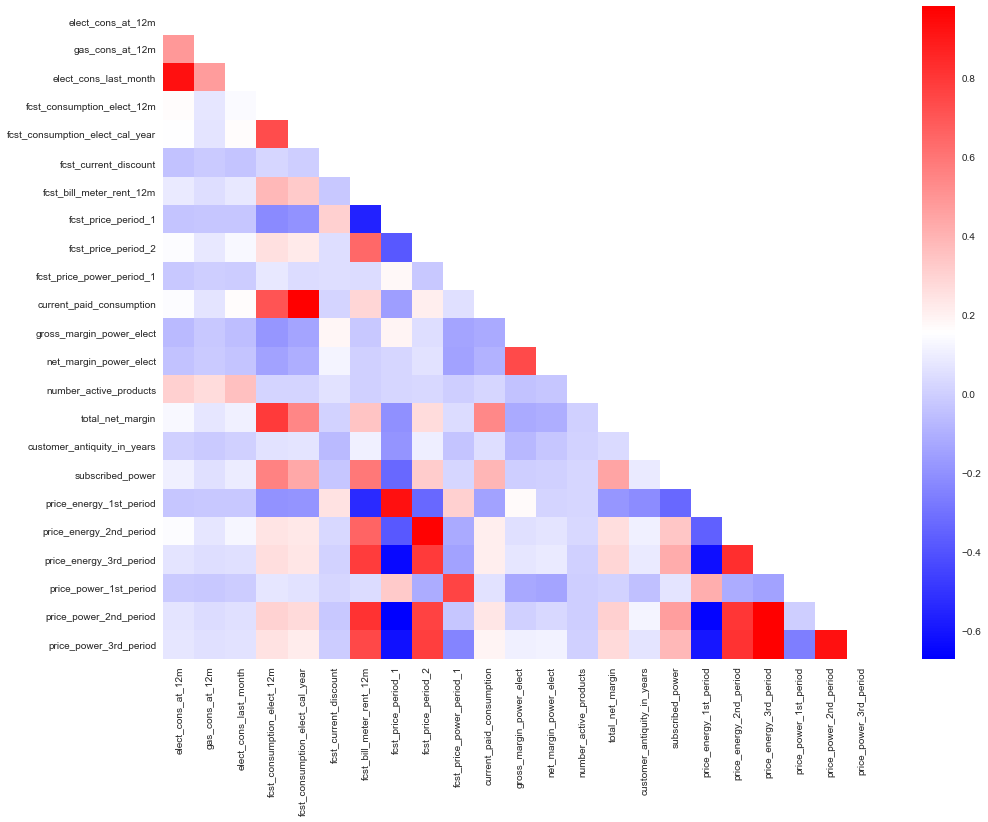

In [64]:
plt.figure(figsize = (16,12))

mask = np.zeros_like(features.corr(), dtype = np.bool)

mask[np.triu_indices_from(mask)] = True

sns.heatmap(features.corr(), mask = mask, cmap = 'bwr')

plt.savefig('../images/corr.png')
plt.show()

In [14]:
features.corr()

,elect_cons_at_12m,gas_cons_at_12m,elect_cons_last_month,fcst_consumption_elect_12m,fcst_consumption_elect_cal_year,fcst_current_discount,fcst_bill_meter_rent_12m,fcst_price_period_1,fcst_price_period_2,fcst_price_power_period_1,current_paid_consumption,gross_margin_power_elect,net_margin_power_elect,number_active_products,total_net_margin,customer_antiquity_in_years,subscribed_power,price_energy_1st_period,price_energy_2nd_period,price_energy_3rd_period,price_power_1st_period,price_power_2nd_period,price_power_3rd_period
elect_cons_at_12m,1.000000,0.485839,0.926037,0.167258,0.148203,-0.043970,0.086577,-0.033123,0.146611,-0.025942,0.145964,-0.065781,-0.044945,0.307047,0.129416,0.004847,0.108078,-0.027919,0.148015,0.064704,-0.014152,0.068351,0.074697
gas_cons_at_12m,0.485839,1.000000,0.476036,0.074424,0.067307,-0.019153,0.047114,-0.030216,0.080915,-0.006249,0.069353,-0.024718,-0.015796,0.266227,0.072379,-0.014641,0.052987,-0.020785,0.075773,0.046254,-0.020704,0.042533,0.053487
elect_cons_last_month,0.926037,0.476036,1.000000,0.135457,0.161057,-0.038684,0.077815,-0.029753,0.132652,-0.007870,0.162469,-0.057134,-0.038979,0.354880,0.107793,0.001313,0.092157,-0.019769,0.128441,0.053235,-0.012027,0.055692,0.061138
fcst_consumption_elect_12m,0.167258,0.074424,0.135457,1.000000,0.729380,0.020021,0.383396,-0.222763,0.252183,0.082178,0.705117,-0.184796,-0.146731,0.016603,0.791818,0.061094,0.557264,-0.199912,0.244626,0.262469,0.074203,0.299656,0.246582
fcst_consumption_elect_cal_year,0.148203,0.067307,0.161057,0.729380,1.000000,-0.006673,0.324778,-0.199167,0.224610,0.044260,0.978817,-0.139257,-0.109076,0.018882,0.545827,0.064714,0.433337,-0.193176,0.230133,0.236133,0.063280,0.274403,0.215945
fcst_current_discount,-0.043970,-0.019153,-0.038684,0.020021,-0.006673,1.000000,-0.021587,0.307074,0.050079,0.045589,0.016167,0.183645,0.121195,0.058134,0.007847,-0.067407,-0.026302,0.248840,0.025643,0.008134,0.020244,-0.022722,-0.009931
fcst_bill_meter_rent_12m,0.086577,0.047114,0.077815,0.383396,0.324778,-0.021587,1.000000,-0.560282,0.642270,0.043395,0.288203,-0.020337,0.000723,0.004303,0.346483,0.105565,0.588916,-0.530215,0.655220,0.785909,0.038811,0.817641,0.741995
fcst_price_period_1,-0.033123,-0.030216,-0.029753,-0.222763,-0.199167,0.307074,-0.560282,1.000000,-0.385017,0.174608,-0.160938,0.190934,0.024885,0.022882,-0.204153,-0.189332,-0.334544,0.924425,-0.385625,-0.641895,0.324756,-0.671477,-0.619361
fcst_price_period_2,0.146611,0.080915,0.132652,0.252183,0.224610,0.050079,0.642270,-0.385017,1.000000,-0.025812,0.211164,0.045950,0.062289,0.030178,0.267523,0.100029,0.319845,-0.334645,0.970974,0.792023,-0.110328,0.767231,0.779261
fcst_price_power_period_1,-0.025942,-0.006249,-0.007870,0.082178,0.044260,0.045589,0.043395,0.174608,-0.025812,1.000000,0.055492,-0.137509,-0.147134,-0.006758,0.041723,-0.035914,0.024156,0.307055,-0.121645,-0.148668,0.760658,-0.031935,-0.245565


Pairs of variables with higher correlation rates:
<ul>
    <li><i>fcst_consumption_elect_cal_year</i> and <i>current_paid_consumption</i>: 0.98</li>
    <li><i>fcst_price_period_2</i> and <i>price_energy_2nd_period</i>: 0.99</li>
    <li><i>price_power_2nd_period</i> and <i>price_energy_3rd_period</i>: 0.97</li>
    <li><i>price_power_3rd_period</i> and <i>price_energy_3rd_period</i>: 0.98</li>
</ul><br>
We shall then drop <i>price_energy_3rd_period</i>, <i>fcst_price_period_2</i> (as we keep historical 2nd period energy prices, after removing 3rd period) and <i>fcst_consumption_elect_cal_year</i> (since we already have a forecast consumption on 12 months).

In [16]:
features = features.drop(['price_energy_3rd_period', 'fcst_price_period_2', 'fcst_consumption_elect_cal_year'], axis=1)

In [17]:
list(features.columns)

['elect_cons_at_12m',
 'gas_cons_at_12m',
 'elect_cons_last_month',
 'contract_activation_date',
 'contract_end_date',
 'contract_renewal_date',
 'fcst_consumption_elect_12m',
 'fcst_current_discount',
 'fcst_bill_meter_rent_12m',
 'fcst_price_period_1',
 'fcst_price_power_period_1',
 'client_got_gas',
 'current_paid_consumption',
 'gross_margin_power_elect',
 'net_margin_power_elect',
 'number_active_products',
 'total_net_margin',
 'customer_antiquity_in_years',
 'code_elect_campaign_first_subs',
 'subscribed_power',
 'price_energy_1st_period',
 'price_energy_2nd_period',
 'price_power_1st_period',
 'price_power_2nd_period',
 'price_power_3rd_period']

### Preprocessing

In [21]:
def preproc(data):
    
    # Numerical features: 
    """let's first adopt an imputation method for missing values based on the distribution's median
    and second standardise</b> data to avoid degradation of the predictive performance of many machine
    learning algorithms."""

    num_data = data.select_dtypes(include=['float64', 'int64']).copy()
    
    # Median imputation
    median_imputer = SimpleImputer(strategy='median')
    num_data.iloc[:,:] = median_imputer.fit_transform(num_data)
    
    # Data scaling
    scaler = StandardScaler()
    num_data.iloc[:, :] = scaler.fit_transform(num_data)
    
    
    
    # Categorical features:
    """let's first impute NAs consisting on the following steps: (i) ordinal encoding as imputation does not work on 
    NA values, (ii) effectively impute NAs with KNN method, (iii) operate an inverse transform function in order
    to 'categorise' back the variables. Second, one hot encoding of the campaign variable. And finally,
    concatenate the categorical dataframe in a single one."""
    
    cat_data = data[['code_elect_campaign_first_subs']].copy()
    
    # Second, impute NAs
    # Ordinal Encoding of cat_data_train DataFrame
    ordinal_enc_dict = {}

    for col_name in cat_data:
        # Create an Ordinal Encoder for col
        ordinal_enc_dict[col_name] = OrdinalEncoder()
        col = cat_data[col_name]
    
        # Select non-null values of columns (Ordinal Encoder does not work with NAs)
        col_not_null = col[col.notnull()]
        reshaped_vals = col_not_null.values.reshape(-1, 1)
        encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
    
        # Store the values to non-null values of the column in data
        cat_data.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)
        
    # Create KNN imputer
    KNN_imputer = KNN()

    # Impute and round the users DataFrame
    cat_data.iloc[:, :] = np.round(KNN_imputer.fit_transform(cat_data))
    
    # Loop over the columns
    for col_name in cat_data:
    
        # Reshape the data
        reshaped = cat_data[col_name].values.reshape(-1, 1)
    
        # Perform inverse transform of the ordinally encoded columns
        cat_data[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)
    
    
    # Third, label binary categorical variable
    got_gas = data['client_got_gas'].copy()
    label_enc = LabelEncoder()
    cat_data['client_got_gas'] = label_enc.fit_transform(got_gas)
    # cat_data['client_got_gas'] = cat_data['client_got_gas'].replace({'f': 0, 't': 1})
    
    # Fourth, get dummies and keep those with lower number of NaNs
    dummies = pd.get_dummies(cat_data['code_elect_campaign_first_subs'])
    
    # Fifth, concatenate dataframes
    cat_data = pd.concat([cat_data, dummies], axis = 1)
    cat_data = cat_data.drop(['code_elect_campaign_first_subs'], axis = 1)
    
    
    
    # Time Series data
    """First, impute NAs with a forward-fill technique and second, convert the data to ordinal"""
    
    ts_data = data.select_dtypes(include=['datetime64[ns]']).copy()
    
    # Forward-fill (interpolation does not work)
    ts_data.iloc[:, :] = ts_data.ffill()
    
    # Convert datetime date to ordinal data
    ts_data.iloc[:, :] = ts_data.applymap(lambda x: x.toordinal())
    
    
    # Concatenate the three dataframes into a single one
    preproc_df = [num_data, cat_data, ts_data]
    all_data = pd.DataFrame(reduce(lambda x, y: x.join(y, on = x.index, how = 'left'), preproc_df))
    
    
    return all_data 
    

In [22]:
features = preproc(features)
print(features.isnull().values.sum())

Imputing row 1/20120 with 0 missing, elapsed time: 18.083
Imputing row 101/20120 with 0 missing, elapsed time: 18.084
Imputing row 201/20120 with 0 missing, elapsed time: 18.084
Imputing row 301/20120 with 0 missing, elapsed time: 18.084
Imputing row 401/20120 with 0 missing, elapsed time: 18.084
Imputing row 501/20120 with 0 missing, elapsed time: 18.084
Imputing row 601/20120 with 0 missing, elapsed time: 18.085
Imputing row 701/20120 with 0 missing, elapsed time: 18.085
Imputing row 801/20120 with 0 missing, elapsed time: 18.085
Imputing row 901/20120 with 0 missing, elapsed time: 18.085
Imputing row 1001/20120 with 0 missing, elapsed time: 18.085
Imputing row 1101/20120 with 0 missing, elapsed time: 18.085
Imputing row 1201/20120 with 0 missing, elapsed time: 18.086
Imputing row 1301/20120 with 0 missing, elapsed time: 18.086
Imputing row 1401/20120 with 0 missing, elapsed time: 18.086
Imputing row 1501/20120 with 0 missing, elapsed time: 18.086
Imputing row 1601/20120 with 0 missi

0


In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, d07d473503c6bef7cf1922fab1f88f3e to 44e27783ba74e3c10aba49fae358fe0b
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   elect_cons_at_12m                 20120 non-null  float64
 1   gas_cons_at_12m                   20120 non-null  float64
 2   elect_cons_last_month             20120 non-null  float64
 3   fcst_consumption_elect_12m        20120 non-null  float64
 4   fcst_current_discount             20120 non-null  float64
 5   fcst_bill_meter_rent_12m          20120 non-null  float64
 6   fcst_price_period_1               20120 non-null  float64
 7   fcst_price_power_period_1         20120 non-null  float64
 8   current_paid_consumption          20120 non-null  float64
 9   gross_margin_power_elect          20120 non-null  float64
 10  net_margin_power_elect            20120 non-null  float64
 11  number_active_

### Train / Test Split

In [29]:
preproc_dataset = features.join(train_output, on = features.index, how = 'left').sort_values(by = 'has_churned_over_next_3m')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(preproc_dataset.drop('has_churned_over_next_3m', axis = 1),
                                                    preproc_dataset['has_churned_over_next_3m'],
                                                    test_size=0.2, random_state = 42, shuffle = False)

In [31]:
y_test.isnull().values.sum()

4024

## Churn prediction
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Logistic Regression

In [101]:
# Initialise the model
clf_lr = LogisticRegression()

# Fit the model
lr = clf_lr.fit(X_train, y_train)

# Predict
lr_y_train_pred = lr.predict(X_train)
lr_y_test_pred = lr.predict(X_test)

lr_y_train_predprob = lr.predict_proba(X_train)

#### Model performance metrics<br>
<ul>
    <li>Accuracy - The % of correctly predicted labels (both Churn and non Churn). However, for imbalanced classes, accuracy may not a good metric:</li>
    <li>Precision - The % of total model's positive class predictions (here-predicted as Churn) that were correctly classied</li>
    <li>Recall - The % of total positive class samples (all churned customers) that were correctly classified</li>
    
</ul>

In [121]:
# Accuracy
lr_accuracy = round(np.mean(cross_val_score(clf_lr, X_train, y_train, scoring="accuracy")), 4)
lr_auc = round(np.mean(cross_val_score(clf_lr, X_train, y_train, scoring="roc_auc")), 4)

print('accuracy score: {},\narea under the curve: {}'.format(lr_accuracy, lr_auc))

# Precision and Recall matrix
lr_precision = precision_score(y_train, lr_y_train_pred)
lr_recall = recall_score(y_train, lr_y_train_pred)
print('training precision: {} and training recall: {}'.format(round(lr_precision, 4), round(lr_recall, 4)))

# Brier Score
lr_bs = brier_score_loss((y_train, lr_y_train_predprob[:, 1])
print('brier score: {}'.format(round(lr_bs, 4)))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, lr_y_train_pred)

# ROC curve plot
sns.set_style('white')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

SyntaxError: invalid syntax (1752352658.py, line 14)

In [123]:
# Regularisation and feature selection
# Initialise the model
clf_l1 = LogisticRegression(penalty = 'l1', C = 0.25, solver = 'liblinear')

# Fit the model
l1 = clf_lr.fit(X_train, y_train)

# Predict
l1_y_train_pred = lr.predict(X_train)
l1_y_test_pred = lr.predict(X_test)

l1_y_train_predprob = lr.predict_proba(X_train)

In [125]:
# Tuning L1 parameters

C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))

l1_metrics[:,0] = C

for index in range(0, len(C)):
    lr = LogisticRegression(penalty = 'l1', C = C[index], solver = 'liblinear')
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    
    l1_metrics[index,1] = np.count_nonzero(lr.coef_)
    l1_metrics[index,2] = accuracy_score(y_train, y_train_pred)
    l1_metrics[index,3] = precision_score(y_train, y_train_pred)
    l1_metrics[index,4] = recall_score(y_train, y_train_pred)
    
col_names = ['C','Non-Zero Coeffs','Accuracy','Precision','Recall']

print(pd.DataFrame(l1_metrics, columns=col_names))

/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


        C  Non-Zero Coeffs  Accuracy  Precision    Recall
0  1.0000             27.0  0.900721   0.333333  0.001881
1  0.5000             28.0  0.900783   0.375000  0.001881
2  0.2500             25.0  0.900783   0.375000  0.001881
3  0.1000             23.0  0.900783   0.333333  0.001254
4  0.0500             21.0  0.900845   0.400000  0.001254
5  0.0250             17.0  0.900845   0.400000  0.001254
6  0.0100             12.0  0.900845   0.000000  0.000000
7  0.0050              7.0  0.900907   0.000000  0.000000
8  0.0025              3.0  0.900907   0.000000  0.000000


/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy score: 0.9007,
area under the curve: 0.6408
training precision: 0.0 and training recall: 0.0


/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


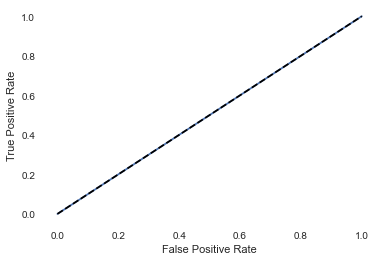

area under the curve score: 0.9007


TypeError: brier_score_loss() missing 1 required positional argument: 'y_prob'

In [124]:
# Accuracy
l1_accuracy = round(np.mean(cross_val_score(clf_l1, X_train, y_train, scoring="accuracy")), 4)
l1_auc = round(np.mean(cross_val_score(clf_l1, X_train, y_train, scoring="roc_auc")), 4)

print('accuracy score: {},\narea under the curve: {}'.format(l1_accuracy, l1_auc))

# Precision and Recall matrix
l1_precision = precision_score(y_train, l1_y_train_pred)
l1_recall = recall_score(y_train, l1_y_train_pred)
print('training precision: {} and training recall: {}'.format(round(l1_precision, 4), round(l1_recall, 4)))

# Brier Score
l1_bs = brier_score_loss((y_train, l1_y_train_predprob[:, 1]))
print('brier score: {}'.format(round(lr_bs, 4)))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, l1_y_train_pred)

# ROC curve plot
sns.set_style('white')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()


### Decision Trees

In [136]:
clf_dt = DecisionTreeClassifier()

# Fit the model
clf_dt = clf_dt.fit(X_train, y_train)

# Predict
clf_dt_y_train_pred = clf_dt.predict(X_train)
clf_dt_y_test_pred = clf_dt.predict(X_test)

clf_dt_y_train_predprob = clf_dt.predict_proba(X_train)

In [139]:
# Accuracy and Area under the curve
clf_dt_accuracy = round(np.mean(cross_val_score(clf_dt, X_train, y_train, scoring="accuracy")), 4)
clf_dt_auc = round(np.mean(cross_val_score(clf_dt, X_train, y_train, scoring="roc_auc")), 4)
print('accuracy score: {},\narea under the curve: {}'.format(clf_dt_accuracy, clf_dt_auc))

accuracy score: 0.8396,
area under the curve: 0.5797


### Random Forest

In [63]:
# Model fitting
clf_rf = RandomForestClassifier()
rf = clf_rf.fit(X_train, y_train)

In [70]:
# Train scores
clf_rf_accuracy = round(np.mean(cross_val_score(clf_rf, X_train, y_train, scoring='accuracy')), 4)
clf_rf_auc = round(np.mean(cross_val_score(clf_rf, X_train, y_train, scoring='roc_auc')), 4)
print('accuracy score: {},\narea under the curve: {}'.format(clf_rf_accuracy, clf_rf_auc))            

accuracy score: 0.9073,
area under the curve: 0.7002


In [75]:
# Hyperparameter tuning with RandomizedSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rscv_rf = RandomizedSearchCV(clf_rf,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='accuracy',
                          random_state=1)

In [129]:
# Train prediction
rscv_rf_y_train_pred = lr.predict(X_train)
rscv_rf_y_test_pred = lr.predict(X_test)

rscv_rf_y_train_predprob = lr.predict_proba(X_train)

# Test prediction
rscv_rf_pred_rscv = rf.predict(X_test)
rscv_rf_predprob_rscv = rf.predict_proba(X_test)

In [74]:
print('best score: {}, best parameters: {}'.format(rscv_rf.best_score_, rscv_rf.best_params_))

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [130]:
# Train scores
clf_rscv_accuracy = round(np.mean(cross_val_score(rscv_rf, X_train, y_train, scoring='accuracy')), 4)
clf_rscv_auc = round(np.mean(cross_val_score(rscv_rf, X_train, y_train, scoring='roc_auc')), 4)
print('accuracy score: {},\narea under the curve: {}'.format(clf_rf_accuracy, clf_rf_auc)) 

# Precision and Recall matrix
clf_rscv_precision = precision_score(y_train, rscv_rf_y_train_pred)
clf_rscv_recall = recall_score(y_train, rscv_rf_y_train_pred)
print('training precision: {} and training recall: {}'.format(round(rscv_rf_precision, 4), round(rscv_rf_recall, 4)))

# Brier Score
rscv_rf_bs = brier_score_loss((y_train, rscv_rf_y_train_predprob[:, 1]))
print('brier score: {}'.format(round(rscv_rf_bs, 4)))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_train, rscv_rf_y_train_pred)

# ROC curve plot
sns.set_style('white')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

accuracy score: 0.9073,
area under the curve: 0.7054


/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'rscv_rf_precision' is not defined

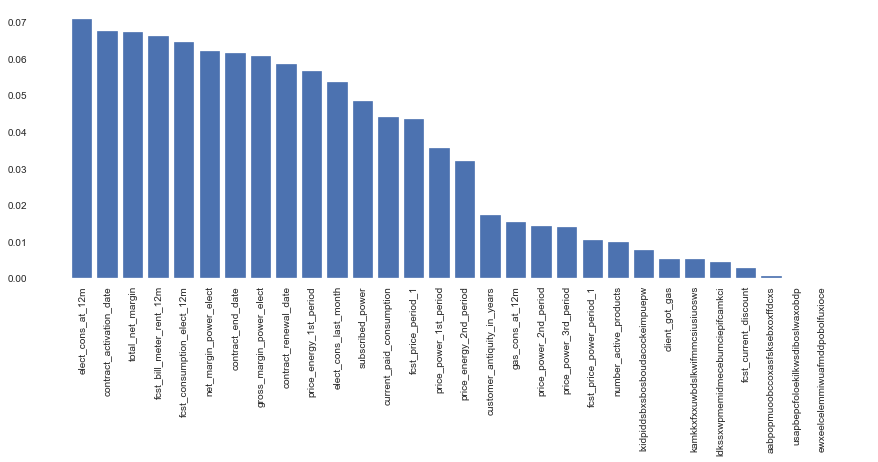

In [132]:
# Feature importances

sns.set_style('white')
plt.rcParams["figure.figsize"] = (15, 5)

# Get feature importances from our gradient boosting model
importances = clf_rf.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(X_train.columns)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

### Support Vector Machines

In [143]:
# Initialise the model
clf_svc = SVC(probability = True)

# Fit the model
svc = clf_svc.fit(X_train, y_train)

# Predict
svc_y_train_predprob = svc.predict_proba(X_train)
svc_y_train_pred = svc.predict(X_test)

In [144]:
svc_accuracy = round(np.mean(cross_val_score(clf_svc, X_train, y_train, cv=5, scoring='accuracy'), 4))
svc_auc = round(np.mean(cross_val_score(clf_svc, X_train, y_train, cv=5, scoring='roc_auc'), 4))

print('accuracy score: {},\n area under the curve: {}'.format(svc_accuracy, svc_auc))

AxisError: axis 4 is out of bounds for array of dimension 1

## Results

In [ ]:
output = pd.read_csv('aily_case_test_output_template.csv', index_col = 'contract_id')
output['does_churn'] = y_pred_rf
output['prob_of_churn'] = y_predprob_rf[:, 1]
output = output.sort_values(by='prob_of_churn', ascending=False)
output.to_csv('../reports/output.csv')

In [146]:
results = pd.read_csv('../reports/output.csv', index_col = 'contract_id')

In [158]:
results.describe()

,does_churn,prob_of_churn
count,4024.000000,4024.000000
mean,0.004722,0.178072
std,0.068561,0.090769
min,0.000000,0.000000
25%,0.000000,0.120000
50%,0.000000,0.160000
75%,0.000000,0.220000
max,1.000000,0.680000


In [157]:
print(results[results['does_churn'] == 1].count())

does_churn       19
prob_of_churn    19
dtype: int64


# Marketing campaign: 20% discount churned custormers
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [ ]:
results